# Phase 4: Data Integration
## Multi-Campus Education Data Preprocessing

This notebook integrates data from multiple campuses:
1. Merge Students, Courses, and Assessments datasets
2. Resolve conflicts (name spellings, course code mismatches)
3. Create unified gold dataset

## Step 1: Import Libraries and Load Transformed Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [30]:
# Load transformed datasets from Phase 3
students_df = pd.read_csv('Outputs/students_transformed.csv')
courses_df = pd.read_csv('Outputs/courses_transformed.csv')
assessments_df = pd.read_csv('Outputs/silver_transformed.csv')

print(f"Students: {students_df.shape}")
print(f"Courses: {courses_df.shape}")
print(f"Assessments: {assessments_df.shape}")

Students: (4500, 19)
Courses: (23719, 11)
Assessments: (56896, 25)


## Step 2: Prepare for Integration - Conflict Resolution

In [31]:
print("="*70)
print("CONFLICT DETECTION AND RESOLUTION")
print("="*70)

# Check for Student_ID conflicts across campuses
print("\n--- Checking Student ID Consistency ---")

# Group by Student_ID and check if names are consistent
student_name_variations = students_df.groupby('Student_ID')['Full_Name'].nunique()
conflicts = student_name_variations[student_name_variations > 1]

if len(conflicts) > 0:
    print(f" Found {len(conflicts)} Student IDs with name variations:")
    for student_id in conflicts.index[:5]:  # Show first 5
        names = students_df[students_df['Student_ID'] == student_id]['Full_Name'].unique()
        print(f"  {student_id}: {names}")
    
    # Resolution: Keep the most common name variation
    print("\n Resolving conflicts by keeping most frequent name...")
    # Already handled in Phase 2 deduplication
else:
    print(" No Student ID conflicts found")

CONFLICT DETECTION AND RESOLUTION

--- Checking Student ID Consistency ---
 No Student ID conflicts found


In [32]:
# Check for Course Code standardization
print("\n--- Checking Course Code Consistency ---")

# All course codes should be standardized from Phase 2
courses_codes = courses_df['Course_Code'].unique()
assessments_codes = assessments_df['Course_Code'].unique()

print(f"Unique course codes in Courses dataset: {len(courses_codes)}")
print(f"Unique course codes in Assessments dataset: {len(assessments_codes)}")

# Check for codes in assessments but not in courses
codes_only_in_assessments = set(assessments_codes) - set(courses_codes)
if len(codes_only_in_assessments) > 0:
    print(f"\n Course codes in Assessments but not in Courses: {codes_only_in_assessments}")
else:
    print("\n All assessment course codes exist in courses dataset")


--- Checking Course Code Consistency ---
Unique course codes in Courses dataset: 10
Unique course codes in Assessments dataset: 10

 All assessment course codes exist in courses dataset


## Step 3: Merge Datasets - Students ↔ Courses ↔ Assessments

In [33]:
print("\n" + "="*70)
print("DATASET INTEGRATION")
print("="*70)

# Step 1: Merge Courses with Students
print("\n--- Step 1: Merging Courses with Students ---")
print(f"Courses before merge: {courses_df.shape}")
print(f"Students before merge: {students_df.shape}")

courses_students = pd.merge(
    courses_df,
    students_df,
    on='Student_ID',
    how='left',
    suffixes=('_course', '_student')
)

print(f"\n Merged result: {courses_students.shape}")
print(f"  Columns: {len(courses_students.columns)}")

# Check for unmatched records
unmatched_students = courses_students['Full_Name'].isnull().sum()
if unmatched_students > 0:
    print(f"   Unmatched student records: {unmatched_students}")
else:
    print(f"   All course records matched with students")


DATASET INTEGRATION

--- Step 1: Merging Courses with Students ---
Courses before merge: (23719, 11)
Students before merge: (4500, 19)

 Merged result: (23719, 29)
  Columns: 29
   All course records matched with students


In [34]:
# Step 2: Merge Assessments with Courses-Students
print("\n--- Step 2: Merging Assessments with Courses-Students ---")
print(f"Assessments before merge: {assessments_df.shape}")
print(f"Courses-Students before merge: {courses_students.shape}")

# Merge on multiple keys
gold_integrated = pd.merge(
    assessments_df,
    courses_students,
    on=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester'],
    how='left',
    suffixes=('', '_enrollment')
)

print(f"\n Final integrated dataset: {gold_integrated.shape}")
print(f"  Rows: {len(gold_integrated):,}")
print(f"  Columns: {len(gold_integrated.columns)}")

# Check for unmatched records
unmatched_enrollments = gold_integrated['Full_Name'].isnull().sum()
if unmatched_enrollments > 0:
    print(f"   Unmatched assessment records: {unmatched_enrollments}")
    print(f"    These assessments don't have matching enrollment records")
else:
    print(f"   All assessment records matched with enrollments")


--- Step 2: Merging Assessments with Courses-Students ---
Assessments before merge: (56896, 25)
Courses-Students before merge: (23719, 29)

 Final integrated dataset: (56896, 50)
  Rows: 56,896
  Columns: 50
   All assessment records matched with enrollments


## Step 4: Handle Duplicate Columns and Clean Up

In [35]:
print("\n" + "="*70)
print("CLEANING UP INTEGRATED DATASET")
print("="*70)

# Identify duplicate column suffixes
duplicate_cols = [col for col in gold_integrated.columns if col.endswith('_course') or col.endswith('_student') or col.endswith('_enrollment')]

print(f"\nDuplicate columns found: {len(duplicate_cols)}")
if len(duplicate_cols) > 0:
    print(f"Examples: {duplicate_cols[:5]}")

# Handle Campus columns
if 'Campus_ID_enrollment' in gold_integrated.columns:
    # Drop the enrollment suffix columns, keep the original
    cols_to_drop = [col for col in gold_integrated.columns if col.endswith('_enrollment')]
    gold_integrated = gold_integrated.drop(columns=cols_to_drop)
    print(f"\n✓ Dropped {len(cols_to_drop)} duplicate enrollment columns")

# Handle other duplicates
if 'Campus_Name_course' in gold_integrated.columns:
    # Keep the student version as it's more authoritative
    gold_integrated = gold_integrated.drop(columns=['Campus_ID_course', 'Campus_Name_course', 'Source_Campus_File_course', 'Upload_Date_course'])
    # Rename student versions to standard names
    rename_dict = {
        'Campus_ID_student': 'Campus_ID',
        'Campus_Name_student': 'Campus_Name',
        'Source_Campus_File_student': 'Source_Campus_File_Student',
        'Upload_Date_student': 'Upload_Date_Student'
    }
    gold_integrated = gold_integrated.rename(columns=rename_dict)
    print(" Resolved campus column conflicts")

print(f"\nFinal shape after cleanup: {gold_integrated.shape}")


CLEANING UP INTEGRATED DATASET

Duplicate columns found: 8
Examples: ['Campus_ID_course', 'Campus_Name_course', 'Source_Campus_File_course', 'Upload_Date_course', 'Campus_ID_student']
 Resolved campus column conflicts

Final shape after cleanup: (56896, 46)


## Step 5: Organize Final Column Structure

In [36]:
print("\n" + "="*70)
print("ORGANIZING FINAL DATASET STRUCTURE")
print("="*70)

# Define desired column order (as per project requirements)
core_columns = [
    # Student Info
    'Student_ID', 'Full_Name', 'Gender', 'DOB',
    # Campus Info
    'Campus_ID', 'Campus_Name',
    # Program Info
    'Program', 'Level', 'Intake_Year',
    # Course Info
    'Course_Code', 'Course_Title', 'Credits',
    # Assessment Info
    'Assessment_Type', 'Mark', 'Grade',
    'Assessment_Date', 'Academic_Year', 'Semester',
    # Additional Info
    'Attendance_Rate',
    # Metadata
    'Source_Campus_File', 'Upload_Date'
]

# Get columns that exist in our dataset
existing_core_cols = [col for col in core_columns if col in gold_integrated.columns]

# Get additional columns (transformed features, etc.)
additional_cols = [col for col in gold_integrated.columns if col not in existing_core_cols]

# Reorder columns
final_column_order = existing_core_cols + additional_cols
gold_integrated = gold_integrated[final_column_order]

print(f"\n Columns organized")
print(f"  Core columns: {len(existing_core_cols)}")
print(f"  Additional columns: {len(additional_cols)}")
print(f"  Total columns: {len(final_column_order)}")

print("\nFirst 20 columns:")
for i, col in enumerate(final_column_order[:20], 1):
    print(f"  {i:2d}. {col}")


ORGANIZING FINAL DATASET STRUCTURE

 Columns organized
  Core columns: 21
  Additional columns: 23
  Total columns: 44

First 20 columns:
   1. Student_ID
   2. Full_Name
   3. Gender
   4. DOB
   5. Campus_ID
   6. Campus_Name
   7. Program
   8. Level
   9. Intake_Year
  10. Course_Code
  11. Course_Title
  12. Credits
  13. Assessment_Type
  14. Mark
  15. Grade
  16. Assessment_Date
  17. Academic_Year
  18. Semester
  19. Attendance_Rate
  20. Source_Campus_File


In [37]:
if 'Mark' in gold_integrated.columns:
    Q1 = gold_integrated['Mark'].quantile(0.25)
    Q3 = gold_integrated['Mark'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = gold_integrated[
        (gold_integrated['Mark'] < lower) | (gold_integrated['Mark'] > upper)
    ]

    print("Mark outliers:", len(outliers))


Mark outliers: 0


## Step 6: Data Quality Validation

In [38]:
# =====================================================
# FORCE Campus_Name to be a REAL single column (Series)
# =====================================================

# 1. If duplicate column names exist → keep first
if gold_integrated.columns.duplicated().any():
    gold_integrated = gold_integrated.loc[:, ~gold_integrated.columns.duplicated()]

# 2. If Campus_Name appears multiple times → keep first
campus_cols = [c for c in gold_integrated.columns if c == 'Campus_Name']
if len(campus_cols) > 1:
    gold_integrated['Campus_Name'] = gold_integrated[campus_cols[0]]

# 3. If Campus_Name is DataFrame → convert to Series
if isinstance(gold_integrated['Campus_Name'], pd.DataFrame):
    gold_integrated['Campus_Name'] = gold_integrated['Campus_Name'].iloc[:, 0]

# 4. If values are lists/arrays → flatten
gold_integrated['Campus_Name'] = gold_integrated['Campus_Name'].apply(
    lambda x: x[0] if isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0 else x
)

# 5. Convert to string & strip spaces
gold_integrated['Campus_Name'] = gold_integrated['Campus_Name'].astype(str).str.strip()

print("Campus_Name fixed ✔")
print("Column type:", type(gold_integrated['Campus_Name']))
print("Dimensions:", gold_integrated['Campus_Name'].shape)

Campus_Name fixed ✔
Column type: <class 'pandas.Series'>
Dimensions: (56896,)


In [39]:
print("\n" + "="*70)
print("INTEGRATED DATA QUALITY VALIDATION")
print("="*70)

print("\n--- Dataset Statistics ---")
print(f"Total records: {len(gold_integrated):,}")
print(f"Unique students: {gold_integrated['Student_ID'].nunique():,}")
print(f"Unique courses: {gold_integrated['Course_Code'].nunique()}")
print(f"Campuses: {gold_integrated['Campus_Name'].nunique()}")

print("\n--- Records by Campus ---")
print(gold_integrated['Campus_Name'].value_counts())

print("\n--- Records by Program ---")
print(gold_integrated['Program'].value_counts())

print("\n--- Missing Values in Core Fields ---")
core_fields = ['Student_ID', 'Full_Name', 'Course_Code', 'Mark', 'Grade']
for field in core_fields:
    missing_count = gold_integrated[field].isnull().sum()
    missing_pct = (missing_count / len(gold_integrated)) * 100
    print(f"  {field}: {missing_count} ({missing_pct:.2f}%)")


INTEGRATED DATA QUALITY VALIDATION

--- Dataset Statistics ---
Total records: 56,896
Unique students: 4,500
Unique courses: 10
Campuses: 3

--- Records by Campus ---
Campus_Name
Rwanda Polytechnic Kigali     19076
Rwanda Polytechnic Huye       18912
Rwanda Polytechnic Musanze    18908
Name: count, dtype: int64

--- Records by Program ---
Program
Information Technology    9873
Mechanical Engineering    9637
Civil Engineering         9526
Software Engineering      9370
Electronics               9322
Computer Science          9168
Name: count, dtype: int64

--- Missing Values in Core Fields ---
  Student_ID: 0 (0.00%)
  Full_Name: 0 (0.00%)
  Course_Code: 0 (0.00%)
  Mark: 0 (0.00%)
  Grade: 0 (0.00%)


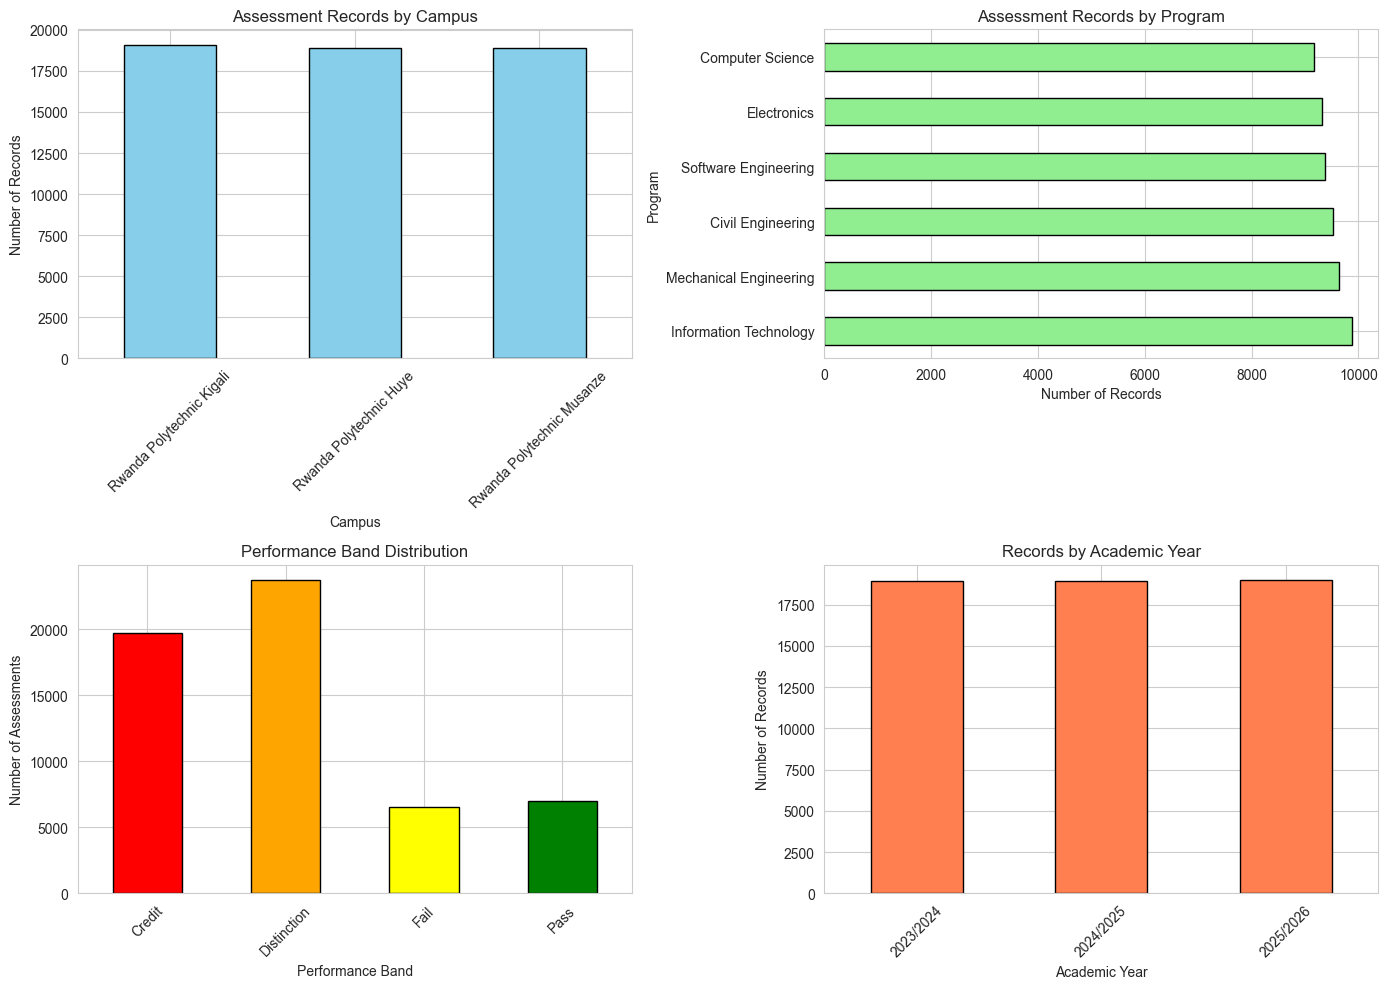

In [40]:
# Visualize integration results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Records by Campus
campus_counts = gold_integrated['Campus_Name'].value_counts()
campus_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Assessment Records by Campus')
axes[0, 0].set_xlabel('Campus')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].tick_params(axis='x', rotation=45)

# Records by Program
program_counts = gold_integrated['Program'].value_counts()
program_counts.plot(kind='barh', ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Assessment Records by Program')
axes[0, 1].set_xlabel('Number of Records')
axes[0, 1].set_ylabel('Program')

# Performance Band Distribution
performance_counts = gold_integrated['Performance_Band'].value_counts().sort_index()
colors = ['red', 'orange', 'yellow', 'green']
performance_counts.plot(kind='bar', ax=axes[1, 0], color=colors, edgecolor='black')
axes[1, 0].set_title('Performance Band Distribution')
axes[1, 0].set_xlabel('Performance Band')
axes[1, 0].set_ylabel('Number of Assessments')
axes[1, 0].tick_params(axis='x', rotation=45)

# Academic Year Distribution
year_counts = gold_integrated['Academic_Year'].value_counts().sort_index()
year_counts.plot(kind='bar', ax=axes[1, 1], color='coral', edgecolor='black')
axes[1, 1].set_title('Records by Academic Year')
axes[1, 1].set_xlabel('Academic Year')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 7: Save Integrated Dataset

In [41]:
# Save gold integrated dataset
gold_integrated.to_csv('Outputs/gold_integrated.csv', index=False)

print("="*70)
print("PHASE 4 COMPLETED SUCCESSFULLY")
print("="*70)
print("\nIntegrated dataset saved:")
print("   Outputs/gold_integrated.csv")
print(f"\nDataset summary:")
print(f"  Rows: {len(gold_integrated):,}")
print(f"  Columns: {len(gold_integrated.columns)}")
print(f"  Students: {gold_integrated['Student_ID'].nunique():,}")
print(f"  Courses: {gold_integrated['Course_Code'].nunique()}")
print(f"  Campuses: {gold_integrated['Campus_Name'].nunique()}")
print("\nNext Step: Run 05_reduction.ipynb")

PHASE 4 COMPLETED SUCCESSFULLY

Integrated dataset saved:
   Outputs/gold_integrated.csv

Dataset summary:
  Rows: 56,896
  Columns: 44
  Students: 4,500
  Courses: 10
  Campuses: 3

Next Step: Run 05_reduction.ipynb


In [42]:

# =========================================================
# GOLD LAYER: CLEANING + VALIDATION (UPDATED)
# =========================================================

import pandas as pd
import numpy as np
import os

print("Starting GOLD layer cleaning and validation...")

# ---------------------------------------------------------
# 1. FIX STRUCTURAL ISSUES (duplicate columns, nested values)
# ---------------------------------------------------------
def ensure_series(df, col):
    if col in df.columns:
        if isinstance(df[col], pd.DataFrame):
            df[col] = df[col].iloc[:, 0]
        df[col] = df[col].apply(
            lambda x: x[0] if isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0 else x
        )
    return df

cols_to_fix = ['Campus_Name', 'Program', 'Full_Name', 'Course_Code']

for c in cols_to_fix:
    if c in gold_integrated.columns:
        gold_integrated = ensure_series(gold_integrated, c)

gold_integrated = gold_integrated.loc[:, ~gold_integrated.columns.duplicated()]
print(" Structural issues fixed")

# ---------------------------------------------------------
# 2. CLEAN TEXT FIELDS
# ---------------------------------------------------------
text_cols = ['Campus_Name', 'Program', 'Full_Name', 'Course_Code']

for col in text_cols:
    if col in gold_integrated.columns:
        gold_integrated[col] = (
            gold_integrated[col]
            .astype(str)
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
        )

print(" Text fields cleaned")

# ---------------------------------------------------------
# 3. CONVERT MARKS TO NUMERIC
# ---------------------------------------------------------
if 'Mark' in gold_integrated.columns:
    gold_integrated['Mark'] = pd.to_numeric(gold_integrated['Mark'], errors='coerce')

print(" Marks converted to numeric")

# ---------------------------------------------------------
# 4. GRADE CONSISTENCY
# ---------------------------------------------------------
def expected_grade(m):
    if pd.isna(m):
        return np.nan
    elif m >= 70:
        return 'A'
    elif m >= 60:
        return 'B'
    elif m >= 50:
        return 'C'
    elif m >= 45:
        return 'D'
    else:
        return 'F'

if 'Mark' in gold_integrated.columns:
    gold_integrated['Expected_Grade'] = gold_integrated['Mark'].apply(expected_grade)

print(" Expected grade calculated")

# ---------------------------------------------------------
# 5. DATA QUALITY VALIDATION
# ---------------------------------------------------------
print("\n" + "="*70)
print("INTEGRATED DATA QUALITY VALIDATION")
print("="*70)

print("\n--- Dataset Statistics ---")
print(f"Total records: {len(gold_integrated):,}")
print(f"Unique students: {gold_integrated['Student_ID'].nunique():,}")
print(f"Unique courses: {gold_integrated['Course_Code'].nunique()}")
print(f"Campuses: {gold_integrated['Campus_Name'].nunique()}")

print("\n--- Records by Campus ---")
print(gold_integrated['Campus_Name'].value_counts(dropna=False))

print("\n--- Records by Program ---")
print(gold_integrated['Program'].value_counts(dropna=False))

print("\n--- Missing Values ---")
core_fields = ['Student_ID', 'Full_Name', 'Course_Code', 'Mark', 'Grade']
for field in core_fields:
    if field in gold_integrated.columns:
        miss = gold_integrated[field].isnull().sum()
        pct = (miss / len(gold_integrated)) * 100
        print(f"{field}: {miss} ({pct:.2f}%)")

# ---------------------------------------------------------
# 6. DUPLICATES & INVALID MARKS
# ---------------------------------------------------------
print("\nDuplicate records:", gold_integrated.duplicated().sum())

if 'Mark' in gold_integrated.columns:
    invalid = gold_integrated[(gold_integrated['Mark'] < 0) | (gold_integrated['Mark'] > 100)]
    print("Invalid marks (<0 or >100):", len(invalid))

# ---------------------------------------------------------
# 7. DATA QUALITY SCORE
# ---------------------------------------------------------
score = 100

for field in ['Student_ID', 'Full_Name', 'Course_Code', 'Mark']:
    if field in gold_integrated.columns:
        score -= gold_integrated[field].isnull().mean() * 20

score -= gold_integrated.duplicated().mean() * 30
score = max(0, round(score, 2))

print("\nDATA QUALITY SCORE:", score, "/ 100")

# ---------------------------------------------------------
# 8. SAVE CLEAN GOLD DATASET
# ---------------------------------------------------------
os.makedirs("Outputs", exist_ok=True)
gold_integrated.to_csv("Outputs/gold_cleaned.csv", index=False)

print(" Clean GOLD dataset saved to Outputs/gold_cleaned.csv")


Starting GOLD layer cleaning and validation...
 Structural issues fixed
 Text fields cleaned
 Marks converted to numeric
 Expected grade calculated

INTEGRATED DATA QUALITY VALIDATION

--- Dataset Statistics ---
Total records: 56,896
Unique students: 4,500
Unique courses: 10
Campuses: 3

--- Records by Campus ---
Campus_Name
Rwanda Polytechnic Kigali     19076
Rwanda Polytechnic Huye       18912
Rwanda Polytechnic Musanze    18908
Name: count, dtype: int64

--- Records by Program ---
Program
Information Technology    9873
Mechanical Engineering    9637
Civil Engineering         9526
Software Engineering      9370
Electronics               9322
Computer Science          9168
Name: count, dtype: int64

--- Missing Values ---
Student_ID: 0 (0.00%)
Full_Name: 0 (0.00%)
Course_Code: 0 (0.00%)
Mark: 0 (0.00%)
Grade: 0 (0.00%)

Duplicate records: 0
Invalid marks (<0 or >100): 0

DATA QUALITY SCORE: 100.0 / 100
 Clean GOLD dataset saved to Outputs/gold_cleaned.csv
